## OPC PDG

# Integrantes: Sandra Niño y Johnatan Garzón

En el presente jupyter notebook se hará uso de LDA (Latent Dirichlet Allocation) para que las respuestas a la pregunta "Para ti,¿Que sí es paz?", en este caso entendidos como documentos, formen topics o categorías de palabras relacionadas  a la pregunta.

In [1]:
%matplotlib inline
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn import datasets, metrics
from sklearn import preprocessing
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns

#remove stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')

import warnings; warnings.simplefilter('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/garzuzo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/garzuzo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Lectura de datos procesados

Creamos el dataframe a partir de los datos procesados anteriormente

In [2]:
df=pd.read_excel('./data/df_limpieza.xlsx')

In [3]:
df.head()

,Narrativa_lemmatized
0,tranquilidad convivencia casa educacion colect...
1,semana semana padres cuidadores pasar hijos es...
2,tranquilidad familia empleabilidad tolerancia ...
3,accion dano integracion comunitaria respeto de...
4,procesos formativo multiplicacion numero alian...


## LDA (Latent Dirichlet Allocation)

Se crea matriz Documento-Palabra como input para LDA.

Se hará uso de CountVectorizer. Este se configurará para que tenga en cuenta palabras que aparezcan como mínimo 10 veces y que solo contengan letras, que su longitud sea de mínimo 3 caracteres y no borre los bigramas(palabras que tienen un guión bajo).

In [4]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimo numero de ocurrencias
                             token_pattern='[a-z\_A-Z]{3,}',  # num chars > 3, que contenga bigramas (palabra_palabra)
                            )

data_vectorized = vectorizer.fit_transform(df['Narrativa_lemmatized'])

Este es un ejemplo de lo que retorna data_vectorized. Esta es una matriz de dispersión que tiene en cuenta las ocurrencias de la palabra en cada documento. 
Por ejemplo, en el primer documento vemos que hay 2 palabras con 2 ocurrencias que son: tranquilidad y educación. 

In [5]:
df.Narrativa_lemmatized[0]

'tranquilidad convivencia casa educacion colectividad respeto tranquilidad acceso educacion humanizacion espacio siempre camino'

In [6]:
print(data_vectorized[0:10])

  (0, 393)	1
  (0, 168)	1
  (0, 2)	1
  (0, 360)	1
  (0, 150)	2
  (0, 67)	1
  (0, 100)	1
  (0, 426)	2
  (1, 183)	1
  (1, 165)	1
  (1, 214)	2
  (1, 437)	2
  (1, 181)	1
  (1, 259)	1
  (1, 213)	2
  (1, 309)	2
  (1, 301)	2
  (1, 168)	1
  (2, 371)	1
  (2, 16)	1
  (2, 449)	1
  (2, 127)	1
  (2, 416)	1
  (2, 214)	1
  (2, 181)	1
  :	:
  (6, 40)	1
  (6, 422)	1
  (6, 83)	1
  (6, 289)	2
  (6, 416)	2
  (7, 362)	1
  (7, 214)	1
  (7, 426)	1
  (8, 140)	1
  (8, 348)	1
  (8, 155)	1
  (8, 26)	1
  (8, 446)	1
  (8, 307)	1
  (8, 85)	1
  (8, 400)	1
  (8, 4)	1
  (8, 77)	1
  (8, 360)	2
  (9, 137)	1
  (9, 287)	1
  (9, 438)	1
  (9, 60)	1
  (9, 289)	1
  (9, 360)	2


A continuación veremos las 20 palabras más comunes en nuestros datos. 

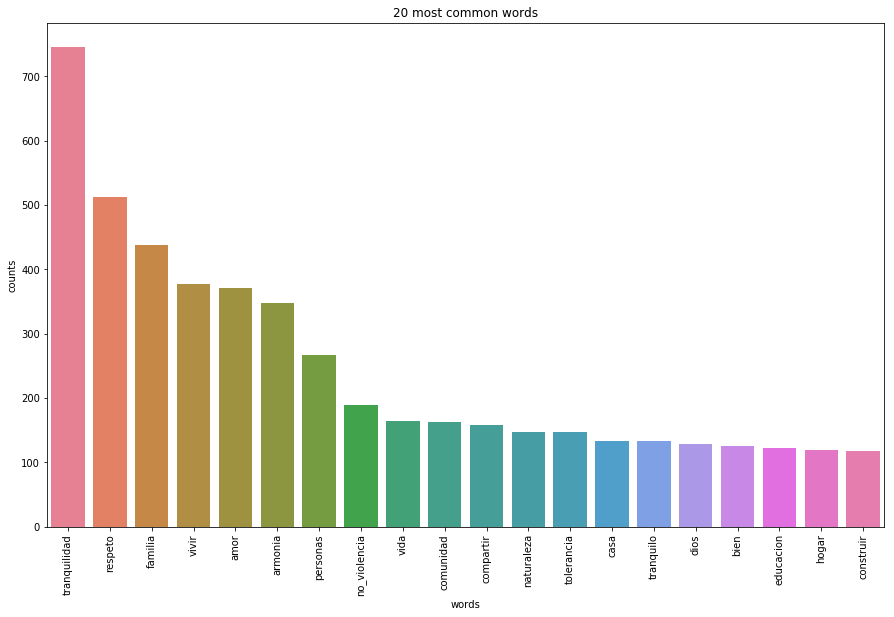

In [7]:
def plot_20_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Visualise the 20 most common words
plot_20_most_common_words(data_vectorized, vectorizer)

## Encontrar el mejor LDA

Realizaremos una búsqueda de parámetros para encontrar el mejor LDA. Para esto se tendrá en cuenta la variación de 2 parámetros:
- n_components, el cual es el número de topicos (grupos) que queremos formar.
- learning_decay, el cual controla la razón de aprendizaje. 

### Grid Search
Este proceso de búsqueda de parámetros consume bastante tiempo, puesto que construye múltiples modelos de LDA para todas las posibles combinaciones de dichos parámetros en el diccionario **param_grid** (cross-validated grid-search).

In [8]:
# Se definen los parámetros de búsqueda
search_params = {'n_components': [10, 15, 20, 25], 'learning_decay': [.5, .7, .9], 'random_state':[100]}

# Se inicializa el modelo
lda = LatentDirichletAllocation()

# Se inicializa la clase GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)

# Se realiza Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25], 'learning_decay': [0.5, 0.7, 0.9], 'random_state': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [9]:
print(model.best_estimator_)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=100,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)


## Escogencia del modelo

Ahora construimos el modelo con los parámetros encontrados en el paso anterior. Para esto asignamos **model.best\_estimator\_** a la variable *lda_model*

In [11]:
# Best Model
lda_model = model.best_estimator_

# Model Parameters
print("Mejores parámetros del modelo: ", model.best_params_)

# Log Likelihood Score
print("Mejor Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Perplexity del modelo: ", lda_model.perplexity(data_vectorized))

Mejores parámetros del modelo:  {'learning_decay': 0.7, 'n_components': 10, 'random_state': 100}
Mejor Log Likelihood Score:  -34554.234643328025
Perplexity del modelo:  358.6854330045643


Ahora graficamos la diferencia entre los diferentes modelos generados. Comparamos los scores de log-likelihood contra el número de tópicos, se ve claramente que el número de tópicos=10 tiene mejores resultados. También se observa que el learning_decay=0.7 tiene un mejor rendimiento que el resto.

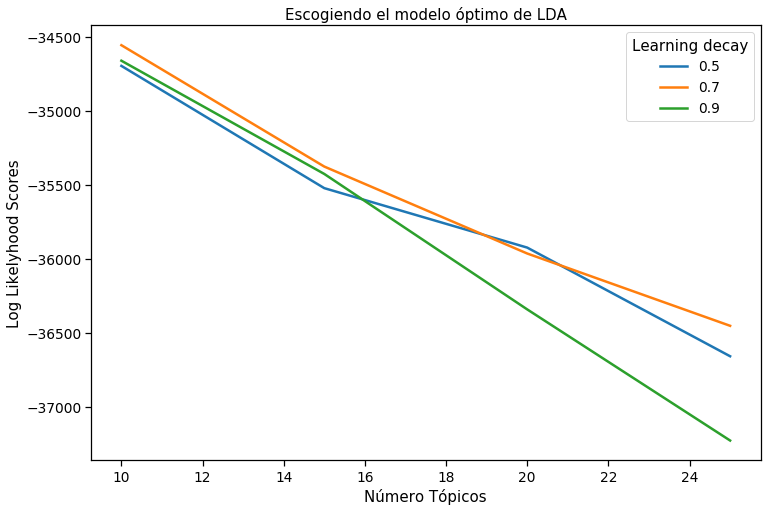

In [12]:
n_topics = [10, 15, 20, 25]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Escogiendo el modelo óptimo de LDA")
plt.xlabel("Número Tópicos")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## Tópico dominante en cada documento

Recordemos que los documentos contienen una mezcla de tópicos (grupos/categorías) y las palabras se agrupan en dichos tópicos. 
Por ende, veremos la proporción de cada tópico en cada documento y la última columna será el topico dominante, es decir, el que tiene mayor proporción. 

In [13]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_output.shape[1])]

# index names
docnames = ["Doc" + str(i) for i in range(lda_output.shape[0])]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.01,0.01,0.44,0.01,0.25,0.01,0.01,0.01,0.25,0.01,2
Doc1,0.01,0.01,0.08,0.81,0.01,0.01,0.01,0.01,0.01,0.07,3
Doc2,0.01,0.01,0.01,0.01,0.23,0.01,0.6,0.01,0.01,0.1,6
Doc3,0.25,0.01,0.01,0.01,0.46,0.01,0.01,0.01,0.01,0.21,4
Doc4,0.33,0.02,0.26,0.02,0.02,0.02,0.27,0.02,0.02,0.02,0
Doc5,0.29,0.31,0.01,0.01,0.18,0.15,0.01,0.01,0.01,0.01,1
Doc6,0.01,0.01,0.61,0.01,0.01,0.01,0.29,0.01,0.01,0.01,2
Doc7,0.03,0.03,0.03,0.03,0.41,0.03,0.39,0.03,0.03,0.03,4
Doc8,0.19,0.01,0.01,0.01,0.01,0.01,0.67,0.08,0.01,0.01,6
Doc9,0.01,0.01,0.39,0.01,0.01,0.01,0.51,0.01,0.01,0.01,6


Por ejemplo, vemos que el documento 0 tiene 44% de las palabras relacionados al topico 2, tiene 25% de las palabras relacionados al topico 4 y 8, y así sucesivamente. 

## Distribución de los tópicos en los documentos

En esta parte vemos la cantidad de documentos asociados a cada tópico. Dicha lista está ordenada de mayor a menor, por tanto el topico 9 es el que tiene asociado una mayor cantidad de documentos.

In [14]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,9,474
1,4,378
2,6,368
3,2,363
4,8,273
5,3,229
6,1,221
7,5,214
8,0,213
9,7,201


## 10 palabras de cada tópico

Hemos hablado de tópico 0,1,2,3, etc. Ahora veremos en realidad cuáles palabras están asociadas a cada tópico. Solo visualizaremos las primeras 10.  

In [15]:
# 18
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

number_words = 10

print_topics(lda_model,vectorizer,number_words)


Topic #0:
igualdad amigos entorno cuidar espacios bienestar acciones seguro construccion calle

Topic #1:
respeto personas demas_personas diferencias contar respeto_hacia tratar raza gente ambiente

Topic #2:
tranquilo sociedad no_violencia vida mejor educacion oportunidades social saber siempre

Topic #3:
armonia felicidad generar hijos corazon vida sana_convivencia alegria ser_humano barrio

Topic #4:
tranquilidad respeto solidaridad confianza personal tolerancia reflejar valores hogar dialogo

Topic #5:
construir mundo libertad respeto armonia lograr perdonar bueno derechos territorio

Topic #6:
amor respeto tolerancia pensar conflictos personas seguridad diferente persona respeto_tolerancia

Topic #7:
dios solo entender existir musica disfrutar escuchar projimo conflicto encuentro

Topic #8:
naturaleza casa sentir convivencia problemas representar llegar conciencia forma tener_buena

Topic #9:
familia vivir comunidad personas armonia compartir bien interior union bueno


Ahora con el uso de la librería pyLDAvis podremos visualizar de manera interactiva la composición de cada topico con sus respectivas palabras, así como la proporción de las mismas en el topico correspondiente. 

In [16]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne', sort_topics= False)


CPU times: user 3.4 s, sys: 154 ms, total: 3.56 s
Wall time: 43.1 s


In [17]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0     -171.771164  -25.800884       1        1   6.022214
1     -250.525848  210.079666       2        1   8.444219
2       -7.364223  340.815552       3        1  13.697643
3     -200.722992 -263.611359       4        1   7.551565
4       35.757351 -103.210075       5        1   6.858671
5       -1.061694  115.127197       6        1   8.989343
6      265.566711 -108.786728       7        1  12.807193
7       58.846851 -329.816650       8        1   8.106873
8     -395.522461  -39.661358       9        1  10.986870
9      228.510178  150.831650      10        1  16.535408, topic_info=    Category        Freq          Term       Total  loglift  logprob
426  Default  676.000000  tranquilidad  676.000000  30.0000  30.0000
26   Default  353.000000          amor  353.000000  29.0000  29.0000
181  Default  404.000000       familia  404.000000  28.0000  28.0000
450  Default  348.000000         vivir  348.000000  27.0000  27.0000
35   Default  324.000000       armonia  324.000000  26.0000  26.0000
..       ...         ...           ...         ...      ...      ...
44   Topic10   28.854229        barrio   62.412845   1.0282  -4.5187
334  Topic10   15.596095      problema   20.557394   1.5235  -5.1339
152  Topic10   25.151010       empezar   85.934901   0.5710  -4.6560
182  Topic10   17.572117      familiar   37.523334   1.0410  -5.0146
284  Topic10   15.691075         ninos   39.094491   0.8868  -5.1278

[434 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
3         1  0.923831           accion
4         1  0.941782         acciones
4         3  0.033635         acciones
5         3  0.958351       aceptacion
6         6  0.448209          aceptar
...     ...       ...              ...
446       4  0.278059             vida
446       7  0.185373             vida
450      10  0.996462            vivir
451       1  0.975973  vivir_tranquilo
452       2  0.945060           volver

[547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

## Exportamos el modelo

Exportamos el modelo LDA para poder predecir futuros textos y clasificarlos en una categoria correspondiente.

In [18]:
from sklearn.externals import joblib

joblib.dump(lda_model,'modelo_entrenado.pkl')

['modelo_entrenado.pkl']

Exportamos el modelo Vectorizer para crear nuevas matrices de dispersión acorde a los datos entrenados.

In [19]:
joblib.dump(vectorizer,'modelo_vectorizer.pkl')

['modelo_vectorizer.pkl']